In [61]:
from lightfm import LightFM
from scipy.io import mmread
from collections import defaultdict
import logging
from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy as np
import math

logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s',
                   level=logging.INFO)

In [21]:
from plotnine import *
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
def measure_auc(X, model, num_threads=1):
    preds = model.predict(user_ids=X.row,
                  item_ids=X.col,
                  user_features=member_features,
                  item_features=song_features,
                  num_threads=num_threads)
    return roc_auc_score(X.data, preds)

In [3]:
%%time
X_train = mmread('data/processed/X_train.mtx')
X_val = mmread('data/processed/X_validation.mtx')
member_features = mmread('data/processed/member_X.mtx')
song_features = mmread('data/processed/song_X.mtx')

CPU times: user 46.6 s, sys: 415 ms, total: 47 s
Wall time: 47 s


In [53]:
alphas = [3**x for x in range(-10, -5)]
components = [1, 5, 10]
iterations = [10]
results = []

NUM_THREADS=6

In [54]:
for a in alphas:
    for nc in components:
        logging.info('fitting alpha = %f, %d components', a, nc)
        these_results = {'alpha': a, 'no_components': nc}
        model = LightFM(no_components=nc,
                        learning_schedule='adagrad',
                        loss='logistic',
                        user_alpha=a,
                        item_alpha=a)
        model.fit_partial(X_train,
                         user_features=member_features,
                         item_features=song_features,
                         epochs=iterations[0],
                         verbose=False,
                         num_threads=NUM_THREADS)
        these_results['train_auc%d' % iterations[0]] = \
            measure_auc(X_train, model, NUM_THREADS)
        these_results['val_auc%d' % iterations[0]] = \
            measure_auc(X_val, model, NUM_THREADS)
        results.append(these_results)

2017-09-30 21:56:39,824 INFO:fitting alpha = 0.000017, 1 components
2017-09-30 21:57:01,880 INFO:fitting alpha = 0.000017, 5 components
2017-09-30 21:57:38,327 INFO:fitting alpha = 0.000017, 10 components
2017-09-30 21:58:30,242 INFO:fitting alpha = 0.000051, 1 components
2017-09-30 21:58:52,519 INFO:fitting alpha = 0.000051, 5 components
2017-09-30 21:59:28,733 INFO:fitting alpha = 0.000051, 10 components
2017-09-30 22:00:19,365 INFO:fitting alpha = 0.000152, 1 components
2017-09-30 22:00:40,831 INFO:fitting alpha = 0.000152, 5 components
2017-09-30 22:01:16,882 INFO:fitting alpha = 0.000152, 10 components
2017-09-30 22:02:07,826 INFO:fitting alpha = 0.000457, 1 components
2017-09-30 22:02:29,649 INFO:fitting alpha = 0.000457, 5 components
2017-09-30 22:03:05,315 INFO:fitting alpha = 0.000457, 10 components
2017-09-30 22:03:57,762 INFO:fitting alpha = 0.001372, 1 components
2017-09-30 22:04:20,264 INFO:fitting alpha = 0.001372, 5 components
2017-09-30 22:04:56,741 INFO:fitting alpha =

In [55]:
df_results = pd.melt(pd.DataFrame(results), ['alpha', 'no_components'], value_name='auc')
df_results['iterations'] = df_results['variable'].apply(lambda s: s.split('auc')[-1]).astype(int)
df_results['data'] = df_results['variable'].apply(lambda s: s.split('_')[0])
df_results['regularization'] = df_results['alpha'].apply(np.log)
df_results.head()

,alpha,no_components,variable,auc,iterations,data,regularization
0,0.000017,1,train_auc10,0.782188,10,train,-10.986123
1,0.000017,5,train_auc10,0.822801,10,train,-10.986123
2,0.000017,10,train_auc10,0.842951,10,train,-10.986123
3,0.000051,1,train_auc10,0.770300,10,train,-9.887511
4,0.000051,5,train_auc10,0.804708,10,train,-9.887511


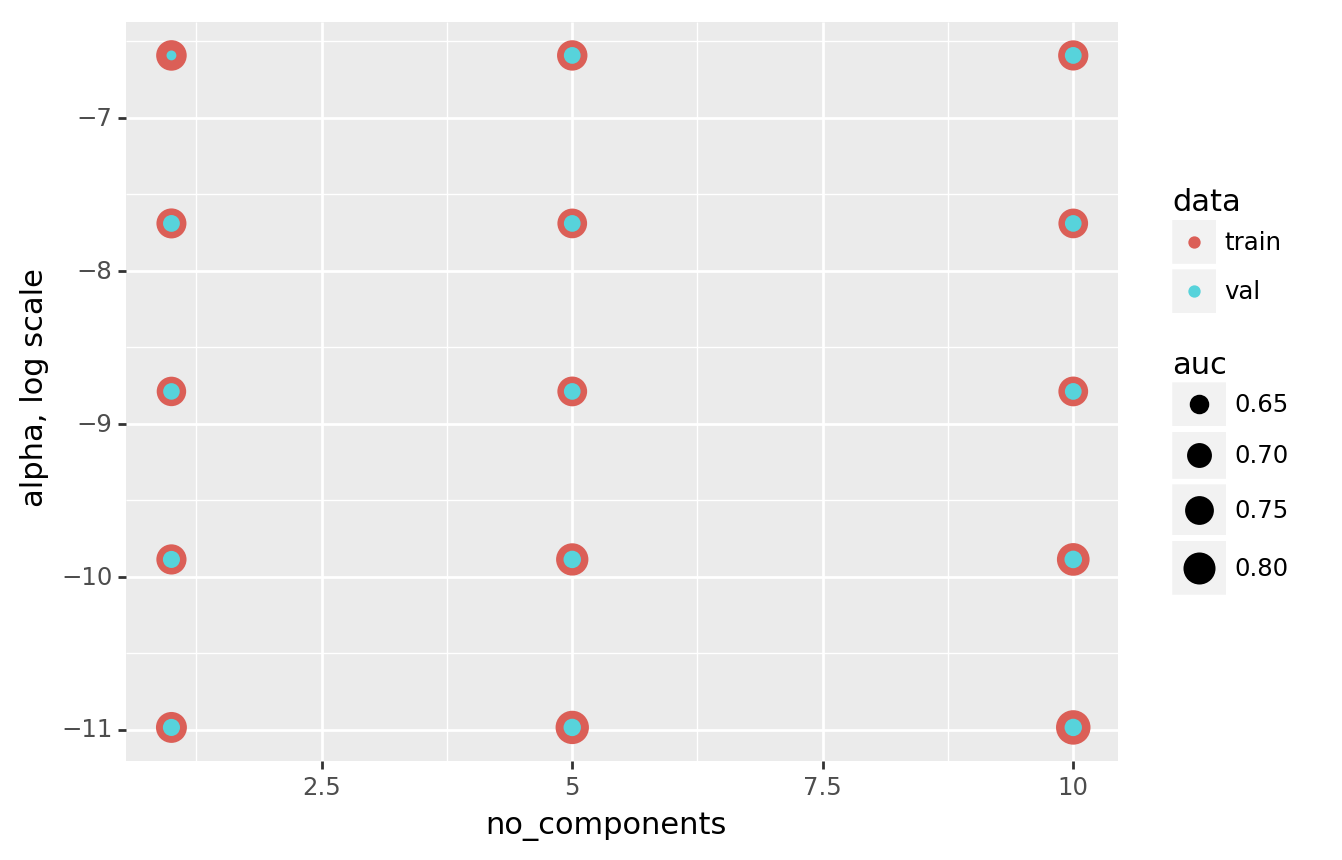

<ggplot: (-9223372036562066172)>

In [56]:
g = (ggplot(df_results.query('iterations > 8'),
        aes('no_components', 'regularization',
                        group='regularization', color='data', size='auc')) +
geom_point() + ylab('alpha, log scale'))
g

In [57]:
g.save('figures/lightfm_hyperparameters_2.png')

/Users/timothysweetser/python/virtualenv/work3/lib/python3.6/site-packages/plotnine/ggplot.py:551: UserWarning: Saving 6.4 x 4.8 in image.
  from_inches(h, units), units))


In [58]:
df_results[df_results.data == 'val'].sort_values('auc', ascending=False).head(3)

,alpha,no_components,variable,auc,iterations,data,regularization
20,0.000051,10,val_auc10,0.637418,10,val,-9.887511
19,0.000051,5,val_auc10,0.636821,10,val,-9.887511
16,0.000017,5,val_auc10,0.636509,10,val,-10.986123


In [64]:
math.log(0.000051, 3)

-8.99651772257374

In [66]:
df_results.query('regularization > -10 & regularization < -9 & data=="val"')

,alpha,no_components,variable,auc,iterations,data,regularization
18,0.000051,1,val_auc10,0.634591,10,val,-9.887511
19,0.000051,5,val_auc10,0.636821,10,val,-9.887511
20,0.000051,10,val_auc10,0.637418,10,val,-9.887511


In [69]:
df_results.query('data == "val"').sort_values('auc', ascending=False).head(3)

,alpha,no_components,variable,auc,iterations,data,regularization
20,0.000051,10,val_auc10,0.637418,10,val,-9.887511
19,0.000051,5,val_auc10,0.636821,10,val,-9.887511
16,0.000017,5,val_auc10,0.636509,10,val,-10.986123
